In [1]:
import sys, os
sys.path.append("..")

import helper as h
from constants import *
from jax import numpy as jnp
from jax.numpy.fft import rfft
import matplotlib.pyplot as plt

from eigenspectrum_plotting_library import image_eig2
import loss_functions as lf

from jax import grad,jit
import jax

import numpy

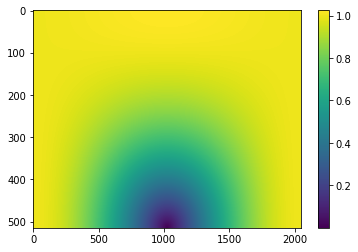

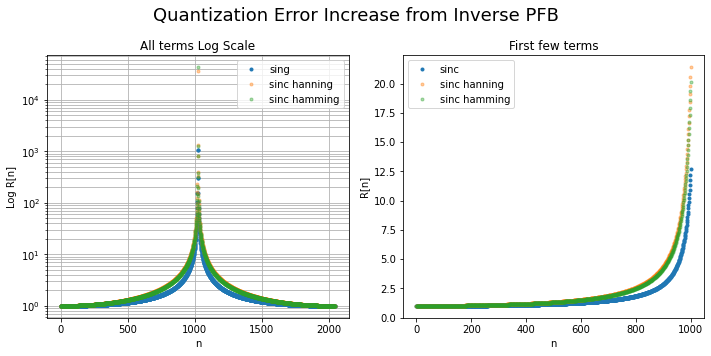

In [2]:
eigengrid = h.r_window_to_matrix_eig(SINC) # h.window_pad_to_box_rfft(SINC,pad_factor=10.0)
eigengrid_hann = h.r_window_to_matrix_eig(SINC * jnp.hanning(len(SINC)))
eigengrid_hamm = h.r_window_to_matrix_eig(SINC * jnp.hamming(len(SINC)))

plt.imshow(abs(eigengrid_hann).T,aspect="auto")
plt.colorbar()
plt.show(block=True)

plt.subplots(figsize=(10,5))
plt.subplot(121)
plt.semilogy(jnp.mean(1/abs(eigengrid**2),axis=1),".",label="sing")
plt.semilogy(jnp.mean(1/abs(eigengrid_hann**2),axis=1),".",alpha=0.4,label="sinc hanning")
plt.semilogy(jnp.mean(1/abs(eigengrid_hamm**2),axis=1),".",alpha=0.4,label="sinc hamming")
plt.title("All terms Log Scale")
plt.ylabel("Log R[n]")
plt.xlabel("n")
plt.grid(which="both")
plt.legend()

plt.subplot(122)
plt.plot(jnp.mean(1/abs(eigengrid[:1000]**2),axis=1),".",label="sinc")
plt.plot(jnp.mean(1/abs(eigengrid_hann[:1000]**2),axis=1),".",alpha=0.4,label="sinc hanning")
plt.plot(jnp.mean(1/abs(eigengrid_hamm[:1000]**2),axis=1),".",alpha=0.4,label="sinc hamming")
plt.title("First few terms")
plt.ylabel("R[n]")
plt.xlabel("n")
plt.legend()
plt.suptitle("Quantization Error Increase from Inverse PFB",fontsize=18)
plt.tight_layout()
plt.savefig("quantization_error_increase_from_inverse_pfb.png")
plt.show(block=True)



# gradient descent

In [3]:
def loss_quantization_error(window):
    eigengrid = h.r_window_to_matrix_eig(window)
    r = jnp.mean(1/abs(eigengrid[:1000]**2),axis=1) # what is plotted above
    return r.mean() # could also just take mean directly, this is more readable

def loss_quantization_error_cheb_hann(cheb_tail,sinc=SINC.copy()):
    len_win=len(sinc)
    cheb_window = h.cheb_win(cheb_tail,len_win)
    w = cheb_window * sinc * jnp.hanning(len_win)
    return loss_quantization_error(w)

def loss_quantization_error_cheb_hann_skip(cheb_tail,n_skip,sinc=SINC.copy()):
    len_win=len(sinc)
    cheb_window = h.cheb_win_skip(cheb_tail,len_win,n_skip)
    w = cheb_window * sinc * jnp.hanning(len_win)
    return loss_quantization_error(w)

def cheb_win_skip(cheb_tail,nskip,len_win):
    """
    param coeffs_tail jnp.ndarray : 1d array of chebyshev coefficients, assuems first chebyshev coefficient is 1.0 (the constant term)
    param len_win int : the length of the SINC window (usually 2048 * 4 I think)
    """
    coeffs = jnp.concatenate([jnp.ones(1),jnp.zeros(nskip),coeffs_tail])
    arr2d = jnp.repeat(jnp.array([jnp.linspace(-1,1,len_win)]),len(coeffs),axis=0)
    arr2d = list(arr2d)
    for idx,row in enumerate(arr2d):
        arr2d[idx] = coeffs[idx] * jnp.cos(idx * row)
    arr2d = jnp.array(arr2d)
    cheb_window = jnp.sum(arr2d,axis=0)
    return cheb_window 


def cheb_win(coeffs_tail,len_win):
    """
    param coeffs_tail jnp.ndarray : 1d array of chebyshev coefficients, assuems first chebyshev coefficient is 1.0 (the constant term)
    param len_win int : the length of the SINC window (usually 2048 * 4 I think)
    """
    coeffs = jnp.concatenate([jnp.ones(1),coeffs_tail])
    arr2d = jnp.repeat(jnp.array([jnp.linspace(-1,1,len_win)]),len(coeffs),axis=0)
    arr2d = list(arr2d)
    for idx,row in enumerate(arr2d):
        arr2d[idx] = coeffs[idx] * jnp.cos(idx * row)
    arr2d = jnp.array(arr2d)
    cheb_window = jnp.sum(arr2d,axis=0)
    return cheb_window 

def cheb_win2(coeffs_tail,len_win):
    """
    param coeffs_tail jnp.ndarray : 1d array of chebyshev coefficients, assuems first chebyshev coefficient is 1.0 (the constant term)
    param len_win int : the length of the SINC window (usually 2048 * 4 I think)
    """
    coeffs = jnp.concatenate([jnp.ones(1),coeffs_tail])
    arr2d = jnp.repeat(jnp.array([jnp.linspace(-1,1,len_win)]),len(coeffs),axis=0)
    l = len(coeffs)
    
    diag = numpy.zeros((l,l))
    numpy.fill_diagonal(diag,numpy.arange(l))
    diag = jnp.array(diag)
    arr2d = jnp.matmul(diag,arr2d)
    arr2d = jnp.cos(arr2d)
    
    # multiply by chebyshev coefficients
    diag_coeffs = numpy.zeros((l,l)) 
    numpy.fill_diagonal(diag_coeffs,numpy.array(coeffs)) 
    diag_coeffs = jnp.array(diag_coeffs) 
    arr2d = jnp.matmul(diag_coeffs,arr2d) 
    
    cheb_window = jnp.sum(arr2d,axis=0) 
    return cheb_window



def loss_quantization_error_cheb_skip(cheb_tail,nskip=50,sinc=SINC.copy()):
    len_win = len(SINC)
    cheb_window = h.cheb_win_skip2(cheb_tail,nskip,len_win)

In [4]:
### load and precompute gradients of loss functions
# loss_eig = lf.loss_eig_hard_thresh_025_cheb_hann
# grad_eig = jit(grad(loss_eig,argnums=0)) 
loss_eig = loss_quantization_error_cheb_hann_skip 
grad_eig = jit(grad(loss_eig,argnums=0)) 

In [5]:
def loss_coeffs(cheb_tail):
    return (cheb_tail**2).sum()

grad_coeffs = jit(grad(loss_coeffs,argnums=0))

In [6]:
coeffs = numpy.random.normal(0,.1,50)
%timeit h.cheb_win(coeffs,len(SINC))

3.74 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# %timeit h.cheb_win_og(coeffs,len(SINC)) # about 34 seconds

loss_eig :		5.420882225036621
grad_eig norm :		0.047446079552173615
loss_coeffs :		0.0
grad_coeffs norm :	0.0
descent rate :		9.394323541300764e-09
--------------------------------------------------------------------


loss_eig :		5.420873641967773
grad_eig norm :		0.051510922610759735
loss_coeffs :		4.736237096958362e-11
grad_coeffs norm :	4.352579594524286e-07
descent rate :		8.023045339200507e-09
--------------------------------------------------------------------


loss_eig :		5.420863628387451
grad_eig norm :		0.055028337985277176
loss_coeffs :		1.630620916071024e-10
grad_coeffs norm :	8.076190169958863e-07
descent rate :		6.85841561320899e-09
--------------------------------------------------------------------


loss_eig :		5.420853137969971
grad_eig norm :		0.05806116759777069
loss_coeffs :		3.169402518210518e-10
grad_coeffs norm :	1.1259490975135122e-06
descent rate :		5.868500352335104e-09
--------------------------------------------------------------------


loss_eig :		5.420

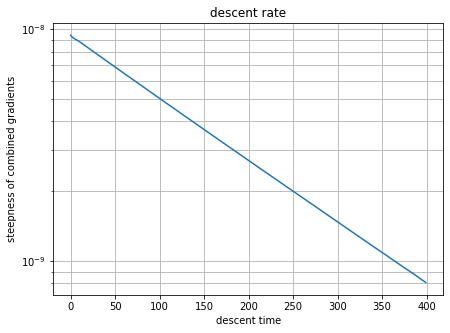


Here are the eigenvalues:


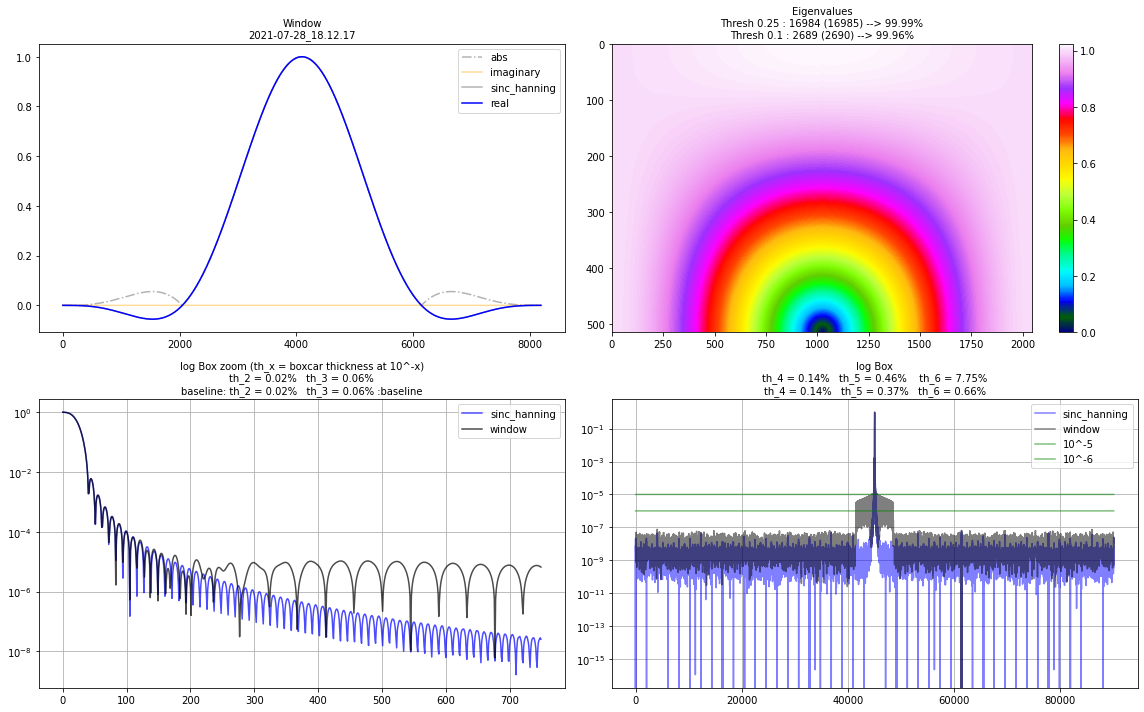


Here are the chebyshev coefficients : 
[-3.02620106e-06 -2.52956397e-06 -1.80604002e-06 -8.93907895e-07
  1.07334614e-07  1.06938307e-06  1.87428395e-06  2.45741285e-06
  2.81619100e-06  2.99388421e-06  3.04357263e-06  2.99214821e-06
  2.82454403e-06  2.49926279e-06  1.98270254e-06  1.27673502e-06
  4.38160043e-07 -4.31549012e-07 -1.21909022e-06 -1.83933423e-06
 -2.25963913e-06 -2.49810955e-06 -2.59985563e-06 -2.60416505e-06
 -2.51983374e-06 -2.32138905e-06 -1.97266081e-06 -1.45416277e-06
 -7.86165856e-07 -3.93491675e-08  6.91350351e-07  1.31588001e-06
  1.77746369e-06  2.06900313e-06  2.21945993e-06  2.26802990e-06
  2.23900634e-06  2.12510395e-06  1.89485911e-06  1.51952247e-06
  9.94989591e-07  3.61056095e-07 -3.08509954e-07 -9.26110999e-07
 -1.42143529e-06 -1.76567994e-06 -1.96715837e-06 -2.05936772e-06
 -2.07143762e-06 -2.01125908e-06 -1.86098714e-06 -1.58352179e-06
 -1.16328931e-06 -6.12126485e-07  1.51915565e-08  6.38455447e-07
  1.18116509e-06  1.58963780e-06  1.85450313e-06  

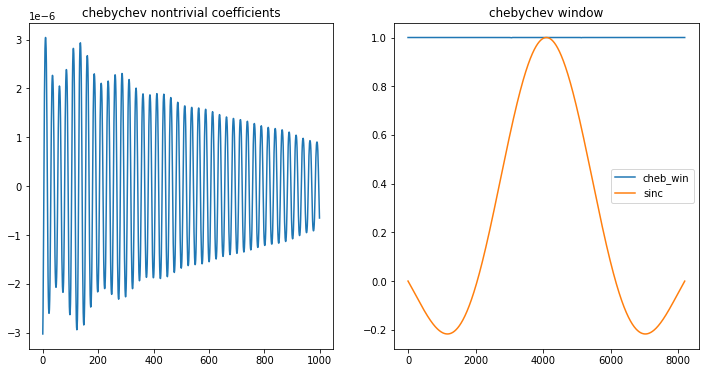

In [12]:
EIG_RATE = 0.0000002     # float
COEFFS_RATE = 0.005     # float      

# initialize cheb coeffs to be zero
n_coeffs = 1000
n_skip = 900

# define loss eig function
loss_eig = lambda x: lf.loss_eig_hard_thresh_025_cheb_hann_skip(x,n_skip=n_skip)
grad_eig = jit(grad(loss_eig,argnums=0)) 

x = jnp.zeros(n_coeffs) 
descent_rate_arr = [] # keeps track of how fast we are descending 

# do gradient descent
for i in range(400): 
    xold = x.copy() # copy the window for keeping track of descent rate

    # descent step 
    x = x - EIG_RATE * grad_eig(x)
    x = x - COEFFS_RATE * grad_coeffs(x) 

    # update descent rate array
    descent_rate = jnp.sqrt(((xold - x)**2).mean())
    descent_rate_arr.append(descent_rate) 

    # print some stats
    if i%25==0:
        print("loss_eig :\t\t{}".format(loss_eig(xold)))
        print("grad_eig norm :\t\t{}".format(jnp.sqrt((grad_eig(xold)**2).mean())))
        print("loss_coeffs :\t\t{}".format(loss_coeffs(xold))) 
        print("grad_coeffs norm :\t{}".format(jnp.sqrt((grad_coeffs(xold)**2).mean())))
        print("descent rate :\t\t{}".format(descent_rate))
        print("----"*17)
        print("\n")
        if descent_rate < 10**(-10):
            print("descent_rate is very slow now, below threshold, stopping descenet")
            break

print("\nFinnished gradient descent\n")


print("\nThis plot is how fast the descent was\n")

# display how fast the descent was
plt.figure(figsize=(7,5))
plt.title("descent rate")
plt.semilogy(descent_rate_arr)
plt.xlabel("descent time") 
plt.ylabel("steepness of combined gradients")
plt.grid(which="both")
plt.show(block=False)
plt.pause(0.05)

print("\nHere are the eigenvalues:")

image_eig2(h.get_modified_sinc_from_cheb(x,win_type="hanning"),win_type="hanning")

print("\nHere are the chebyshev coefficients : \n{}".format(x))

plt.subplots(figsize=(12,6))
plt.subplot(121)
plt.plot(x)
plt.title("chebychev nontrivial coefficients")
plt.subplot(122)
plt.title("chebychev window")
plt.plot(h.cheb_win(x,len(SINC)),label="cheb_win")
plt.plot(SINC,label="sinc")
plt.legend()
plt.show()



# more playing

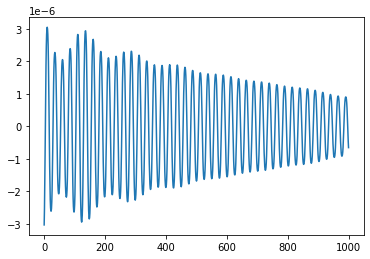

In [13]:
x_old = x.copy()
plt.plot(x_old)


Here are the eigenvalues:


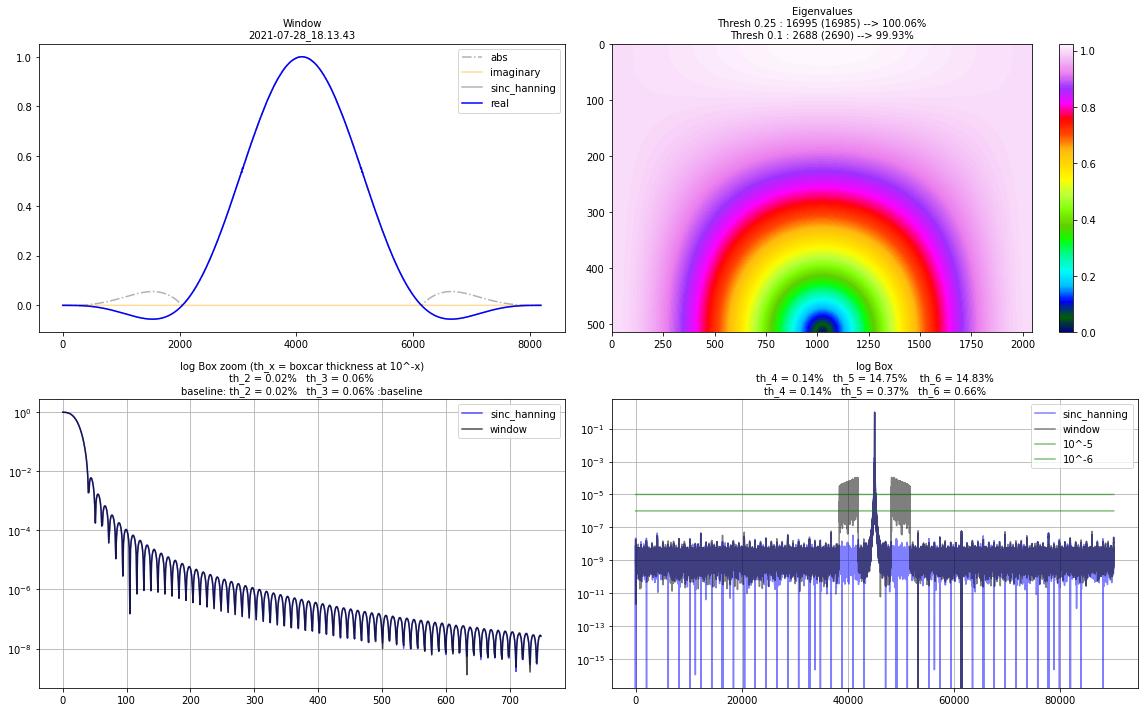


Here are the chebyshev coefficients : 
[-3.02620101e-05 -2.52956397e-05 -1.80604002e-05 -8.93907873e-06
  1.07334608e-06  1.06938305e-05  1.87428395e-05  2.45741285e-05
  2.81619104e-05  2.99388412e-05  3.04357272e-05  2.99214826e-05
  2.82454403e-05  2.49926270e-05  1.98270245e-05  1.27673502e-05
  4.38160032e-06 -4.31549006e-06 -1.21909025e-05 -1.83933425e-05
 -2.25963922e-05 -2.49810946e-05 -2.59985572e-05 -2.60416509e-05
 -2.51983365e-05 -2.32138900e-05 -1.97266090e-05 -1.45416279e-05
 -7.86165856e-06 -3.93491689e-07  6.91350351e-06  1.31588004e-05
  1.77746369e-05  2.06900313e-05  2.21945993e-05  2.26802986e-05
  2.23900643e-05  2.12510386e-05  1.89485909e-05  1.51952245e-05
  9.94989568e-06  3.61056095e-06 -3.08509948e-06 -9.26110988e-06
 -1.42143526e-05 -1.76567992e-05 -1.96715846e-05 -2.05936776e-05
 -2.07143767e-05 -2.01125913e-05 -1.86098714e-05 -1.58352177e-05
 -1.16328929e-05 -6.12126496e-06  1.51915572e-07  6.38455458e-06
  1.18116513e-05  1.58963776e-05  1.85450317e-05  

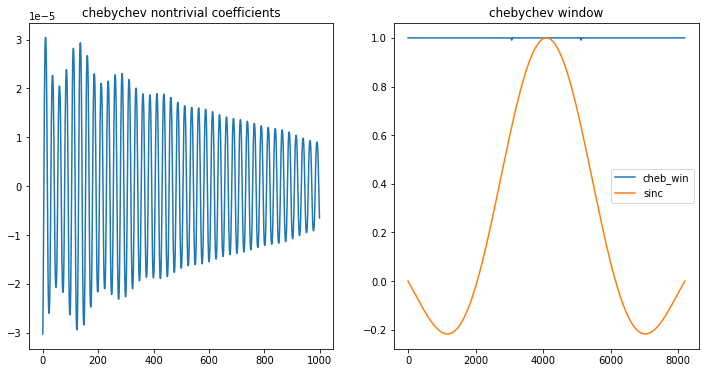

In [14]:
x = x_old.copy() * 10

print("\nHere are the eigenvalues:")

image_eig2(h.get_modified_sinc_from_cheb(x,win_type="hanning",n_skip=n_skip),
           win_type="hanning")

print("\nHere are the chebyshev coefficients : \n{}".format(x))

plt.subplots(figsize=(12,6))
plt.subplot(121)
plt.plot(x)
plt.title("chebychev nontrivial coefficients")
plt.subplot(122)
plt.title("chebychev window")
plt.plot(h.cheb_win(x,len(SINC)),label="cheb_win")
plt.plot(SINC,label="sinc")
plt.legend()
plt.show()



In [9]:
arr = np.linspace(-1,1,4)
g = np.repeat(np.array([arr]),2,axis=0)
g = list(g)
for idx,array in enumerate(g):
    g[idx] = idx*array
g = np.array(g)
g=np.apply_along_axis(np.cos,0,g)
np.sum(g,axis=0)

DeviceArray([1.5403023, 1.944957 , 1.944957 , 1.5403023], dtype=float32)

In [38]:

np.apply_along_axis(lambda x:x**2,0,g)

DeviceArray([[1.        , 0.11111107, 0.11111113, 1.        ],
             [1.        , 0.11111107, 0.11111113, 1.        ]],            dtype=float32)